In [2]:
import pandas as pd
import numpy as np
import tensorflow 
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from tensorflow.keras import optimizers

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
#scaler = StandardScaler()
scaler = MinMaxScaler()

### Ejercicio clase

In [4]:
filename = r"C:\Users\Dell7400\Documents\Ale\Facu\Aprendizaje_Supervisado\Data\Gitters.csv"
#filename = "../data/hitters.csv"
df = pd.read_csv(filename).dropna()
print(df.shape)
df["target"]= np.where(df.NewLeague=="A",1,0)
df = df.drop(columns={"NewLeague"})
df.head()

(263, 20)


,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,target
0,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,0
1,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,1
2,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,0
3,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,0
4,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,1


In [5]:
# le saco los object, podria pasarlo a dummie pero lo hago despues
df_numeric = df[df.columns[df.dtypes!="object"]]


`MinMaxScaler` trabaja sobre un array bidimensional, no tiene sentido iterar sobre las columnas del dataframe.

Nota: ojo que justo `MinMaxScaler` deja el `target` sin cambiar, pero en general no sé si es conveniente escalarlo como a los predictores.

In [6]:
df_numeric = pd.DataFrame(
    data=scaler.fit_transform(df_numeric),
    columns=df_numeric.columns
)

In [14]:
model = Sequential()
# input_dim e input_shape se superponen en funcionalidad, basta con pasar uno solo
#model.add(Dense(50, activation='relu',input_dim=df_numeric.shape[1] - 1)) # ver aca el input_shape para que sirve 
model.add(Dense(1, activation='sigmoid',input_dim=df_numeric.shape[1] - 1)) # ver aca el input_shape para que sirve 


In [15]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 1)                 18        
                                                                 
Total params: 18
Trainable params: 18
Non-trainable params: 0
_________________________________________________________________


Esta celda estaba más abajo pero si no está acá no puedo mirar `training_data.shape` en la celda siguiente.

In [16]:
target_data = df_numeric["target"]
training_data = df_numeric.drop(columns={"target"})

In [17]:
training_data.shape

(263, 17)

In [18]:
#opt = keras.optimizers.optimizer_rmsprop(learning_rate=0.01)
"""
opt = keras.optimizers.RMSprop(
    learning_rate=0.01,
    rho=0.9,
    momentum=0.0,
    epsilon=1e-07,
    centered=False,
    name="RMSprop")

model.compile(loss='mse',
              optimizer=opt,
              metrics=['acc', "mse"]) # aca puedo poner mse, que cambia?
              #              metrics=list("mean_absolute_error"))

    
    
opt = keras.optimizers.RMSprop(
    learning_rate=0.01,
    rho=0.9,
    momentum=0.0,
    epsilon=1e-07,
    centered=False,
    name="RMSprop")
"""
model.compile(loss='binary_crossentropy',
              optimizer="rmsprop",
              metrics=['acc', "mse"]) # aca puedo poner mse, que cambia?
              #              metrics=list("mean_absolute_error"))


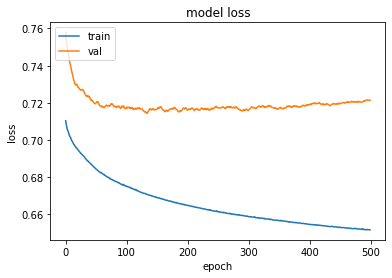

In [19]:
history = model.fit(training_data, target_data,validation_split = 0.1, epochs=500, verbose=0)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [21]:
model.predict(training_data).mean(),target_data.mean()

(0.545221, 0.5361216730038023)

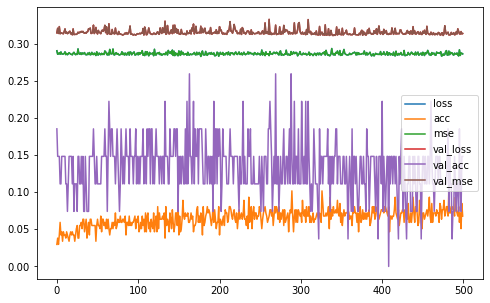

In [67]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()


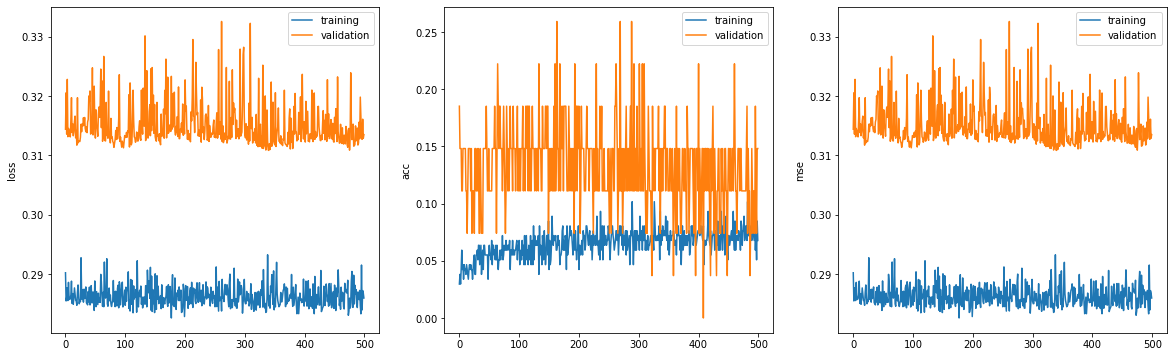

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns
df_history = pd.DataFrame(history.history)
plt.figure(figsize=(20, 6))
plt.subplot(1, 3, 1)
sns.lineplot(data=df_history.loss, label="training")
sns.lineplot(data=df_history.val_loss, label="validation")
plt.subplot(1, 3, 2)
sns.lineplot(data=df_history.acc, label="training")
sns.lineplot(data=df_history.val_acc, label="validation")
plt.subplot(1, 3, 3)
sns.lineplot(data=df_history.mse, label="training")
sns.lineplot(data=df_history.val_mse, label="validation")
plt.legend()
plt.show()

In [107]:
model.predict(training_data).shape

(263, 50)

Para mí, el modelo tiene 3 problemas críticos:
1. no tiene regularización alguna (pensá que 50 neuronas por 17 inputs + intercept te dan 900 pesos para 263 datos),
2. no define una capa de salida razonable (para clasificación, una layer dense da 1 neurona con activación sigmoidea sería lo típico, como en regresión logística), y
3. el error cuadrático medio es una típica pérdida de regresión, no de clasificación (lo tradicional sería usar "binary_crossentropy", que es otro nombre para la log-loss de regresión logística.

In [174]:
model = Sequential()
# input_dim e input_shape se superponen en funcionalidad, basta con pasar uno solo
model.add(Dense(50, activation='relu',input_dim=df_numeric.shape[1] - 1)) # ver aca el input_shape para que sirve 
model.add(keras.layers.Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 50)                900       
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 51        
Total params: 951
Trainable params: 951
Non-trainable params: 0
_________________________________________________________________


In [175]:
#opt = keras.optimizers.optimizer_rmsprop(learning_rate=0.01)

opt = keras.optimizers.RMSprop(
    learning_rate=0.01,
    rho=0.9,
    momentum=0.0,
    epsilon=1e-07,
    centered=False,
    name="RMSprop")

model.compile(loss='binary_crossentropy',
              optimizer="rmsprop",
              metrics=['acc', "mse"]) # aca puedo poner mse, que cambia?
              #              metrics=list("mean_absolute_error"))


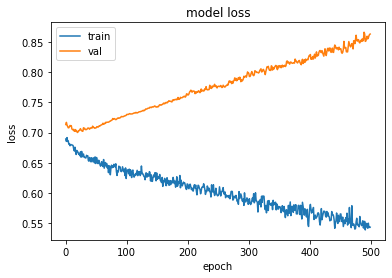

In [176]:
history = model.fit(training_data, target_data,validation_split = 0.1, epochs=500, verbose=0)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

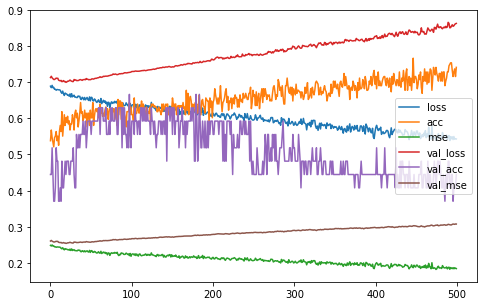

In [177]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()


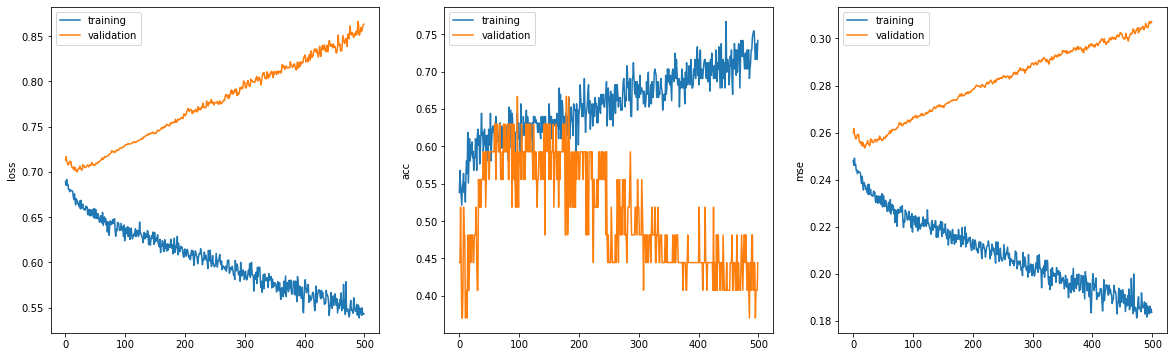

In [178]:
import matplotlib.pyplot as plt
import seaborn as sns
df_history = pd.DataFrame(history.history)
plt.figure(figsize=(20, 6))
plt.subplot(1, 3, 1)
sns.lineplot(data=df_history.loss, label="training")
sns.lineplot(data=df_history.val_loss, label="validation")
plt.subplot(1, 3, 2)
sns.lineplot(data=df_history.acc, label="training")
sns.lineplot(data=df_history.val_acc, label="validation")
plt.subplot(1, 3, 3)
sns.lineplot(data=df_history.mse, label="training")
sns.lineplot(data=df_history.val_mse, label="validation")
plt.legend()
plt.show()

In [190]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

def accuracy(pred, truth):
    return np.mean(pred == truth)

In [191]:
X.shape

(263, 17)

In [192]:
accs = []
for _ in range(20):
    print(".", end="")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    lr_mod = LogisticRegression(max_iter=10000)
    lr_fit = lr_mod.fit(X_train, y_train)
    y_pred = lr_fit.predict(X_test)
    accs.append(accuracy(y_test, y_pred))

....................

In [193]:
pd.Series(accs).describe()

count    20.000000
mean      0.567925
std       0.071886
min       0.452830
25%       0.523585
50%       0.584906
75%       0.589623
max       0.735849
dtype: float64

In [194]:
y.mean()

0.5361216730038023